# Simple experiment on synthetic data to validate the method

This is the first experiment ran on a very simplified synthetic dataset. The data contains 4 anomalies, all of which are spatially separated and their amplitudes are relatively even. The data is only contaminated with pseudo-random Gaussian noise. The idea behind this simple test is to very that the method works under idea conditions and to illustrate the several processing steps.

## Imports

Load the modules needed to run the experiment.

In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import skimage.exposure
import harmonica as hm
import verde as vd
# Our custom module for this paper
import micromag as mg

import mplstereonet

## Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 1.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 50, 0, 50],  # µm
    shape=(250, 250),  # µm
    extra_coords=sensor_sample_distance,
)

Now create the dipole model that will be used to generate the data.

In [3]:
yc = 25
xc = 25
zc = -1
dec = 90
inc = 0
amp = 1e-14

size = 200

np.random.seed(3)

xc_volume = np.random.normal(xc, 0.65, size)
yc_volume = np.random.normal(yc, 0.65, size)
zc_volume = abs(np.random.normal(zc, 0.65, size))*(-1)
dec_volume = np.random.normal(dec, 10, size)
inc_volume = np.random.normal(inc, 10, size)
amp_volume = np.random.normal(amp, 5e-14, size)
    
dipole_coordinates = (
    xc_volume,  # µm
    yc_volume,  # µm
    zc_volume,  # µm
)
dipole_moments = mg.angles_to_vector(
    inc_volume,
    dec_volume,
    amp_volume,
)

# dipole_moments

Calculate the $b_z$ magnetic field of the dipoles and place them into an `xarray.DataArray` for easier handling.

In [4]:
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 250, x: 250)
Coordinates:
  * x        (x) float64 0.0 0.2008 0.4016 0.6024 0.8032 ... 49.4 49.6 49.8 50.0
  * y        (y) float64 0.0 0.2008 0.4016 0.6024 0.8032 ... 49.4 49.6 49.8 50.0
    z        (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
Data variables:
    bz       (y, x) float64 -166.9 -168.8 -170.6 -172.5 ... 295.9 292.5 289.2

Make a quick plot of the calculated field.

24.953986087211078 25.03559466432492 -1.0096276904481303


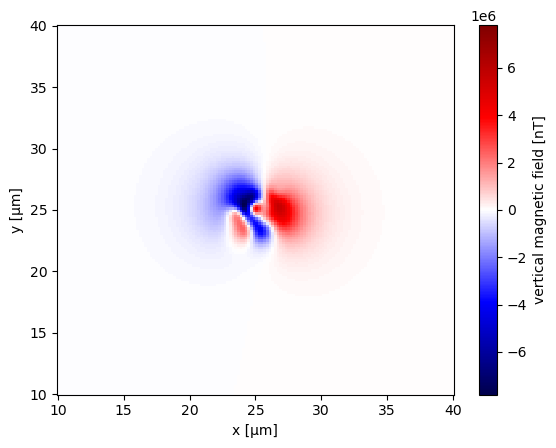

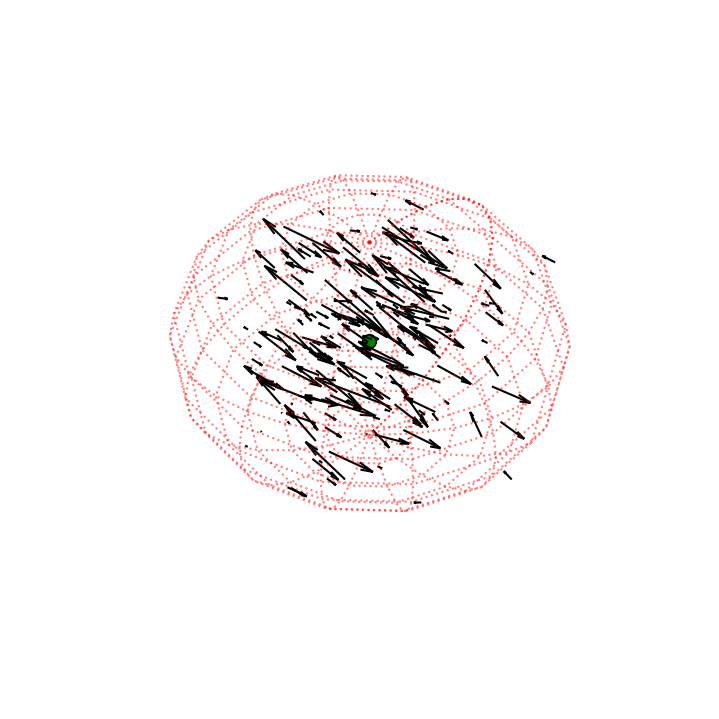

In [5]:
data.bz.sel(x=slice(10,40), y=slice(10,40)).plot.pcolormesh(cmap="seismic")
# plt.scatter(xc_volume.mean(), yc_volume.mean(), color='g', edgecolor='k', zorder=5, alpha=0.7)
# plt.scatter(xc_volume, yc_volume, color='g', alpha=0.2)
print(xc_volume.mean(), yc_volume.mean(), zc_volume.mean())


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
# ax.scatter(xc_volume, yc_volume, zc_volume)
ax.scatter(xc_volume.mean(), yc_volume.mean(), zc_volume.mean(), s=100, color='g', edgecolor='k', zorder=5, alpha=1.0)

dipole_mom = np.max(np.sqrt(dipole_moments[:,0]**2+dipole_moments[:,1]**2+dipole_moments[:,2]**2))

ax.quiver(xc_volume, yc_volume, zc_volume,
          dipole_moments[:,0]/dipole_mom,  
          dipole_moments[:,1]/dipole_mom, 
          dipole_moments[:,2]/dipole_mom, 
          length=1.0, normalize=False, edgecolor='k', pivot='middle')

# ax.plot_trisurf(xc_volume, yc_volume, zc_volume, color='gray', alpha=0.2)



ax.set_xlabel("x ($\mu m$)")
ax.set_ylabel("y ($\mu m$)")
ax.set_zlabel("z ($\mu m$)")

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# plot sphere

u = np.linspace(0, np.pi, 15)
v = np.linspace(0, 2 * np.pi, 15)

x = abs(xc_volume.max()-xc_volume.min())/1.75*np.outer(np.sin(u), np.sin(v))+xc_volume.mean()
y = abs(yc_volume.max()-yc_volume.min())/1.75*np.outer(np.sin(u), np.cos(v))+yc_volume.mean()
z = abs(zc_volume.max()-zc_volume.min())/2*np.outer(np.cos(u), np.ones_like(v))+zc_volume.mean()

ax.plot_wireframe(x, y, z, linestyle=':', alpha=0.5, color='r')

ax.view_init(elev=45, azim=-50)



plt.tight_layout(pad=0, h_pad=0, w_pad=0)

ax.set_axis_off()

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.show()

Add some random noise to make it more realistic.

In [6]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

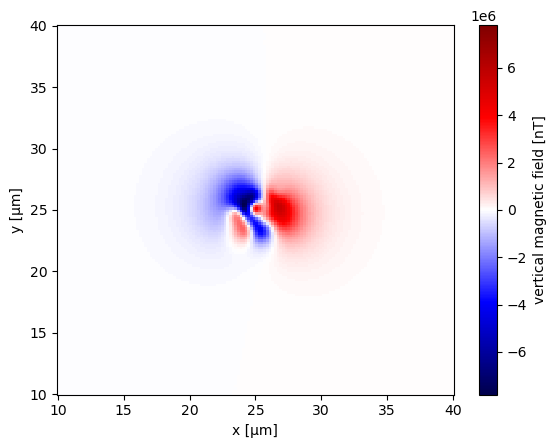

In [7]:
data.bz.sel(x=slice(10,40), y=slice(10,40)) .plot.pcolormesh(cmap="seismic")

### Upward continue the data to suppress the noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [8]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 250, x: 250)
Coordinates:
  * y        (y) float64 0.0 0.2008 0.4016 0.6024 0.8032 ... 49.4 49.6 49.8 50.0
  * x        (x) float64 0.0 0.2008 0.4016 0.6024 0.8032 ... 49.4 49.6 49.8 50.0
    z        (y, x) float64 6.0 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0 6.0
Data variables:
    bz       (y, x) float64 50.03 14.11 -21.74 -57.52 ... 189.2 153.4 117.4 81.5

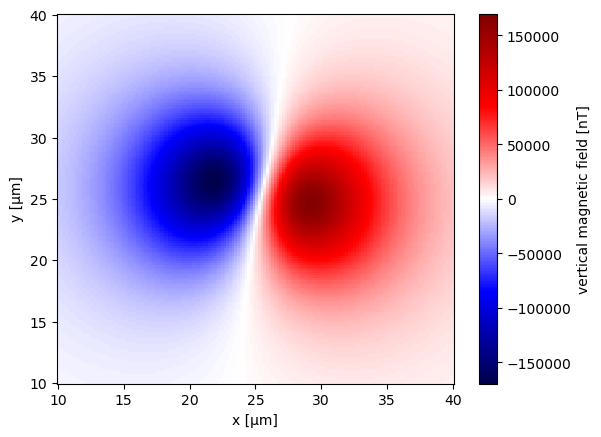

In [9]:
data_up.bz.sel(x=slice(10,40), y=slice(10,40)).plot.pcolormesh(cmap="seismic")

In [10]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 250, x: 250)
Coordinates:
  * y        (y) float64 0.0 0.2008 0.4016 0.6024 0.8032 ... 49.4 49.6 49.8 50.0
  * x        (x) float64 0.0 0.2008 0.4016 0.6024 0.8032 ... 49.4 49.6 49.8 50.0
    z        (y, x) float64 6.0 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0 6.0
Data variables:
    bz       (y, x) float64 50.03 14.11 -21.74 -57.52 ... 189.2 153.4 117.4 81.5
    tga      (y, x) float64 180.4 180.3 180.1 179.8 ... 179.3 179.9 180.2 180.4
    x_deriv  (y, x) float64 -178.8 -178.7 -178.4 -177.9 ... -178.6 -178.9 -179.0
    y_deriv  (y, x) float64 22.64 22.65 22.69 22.75 ... 20.86 21.15 21.46 21.79
    z_deriv  (y, x) float64 -6.45 -8.474 -10.53 -12.62 ... -0.8723 -2.89 -4.897

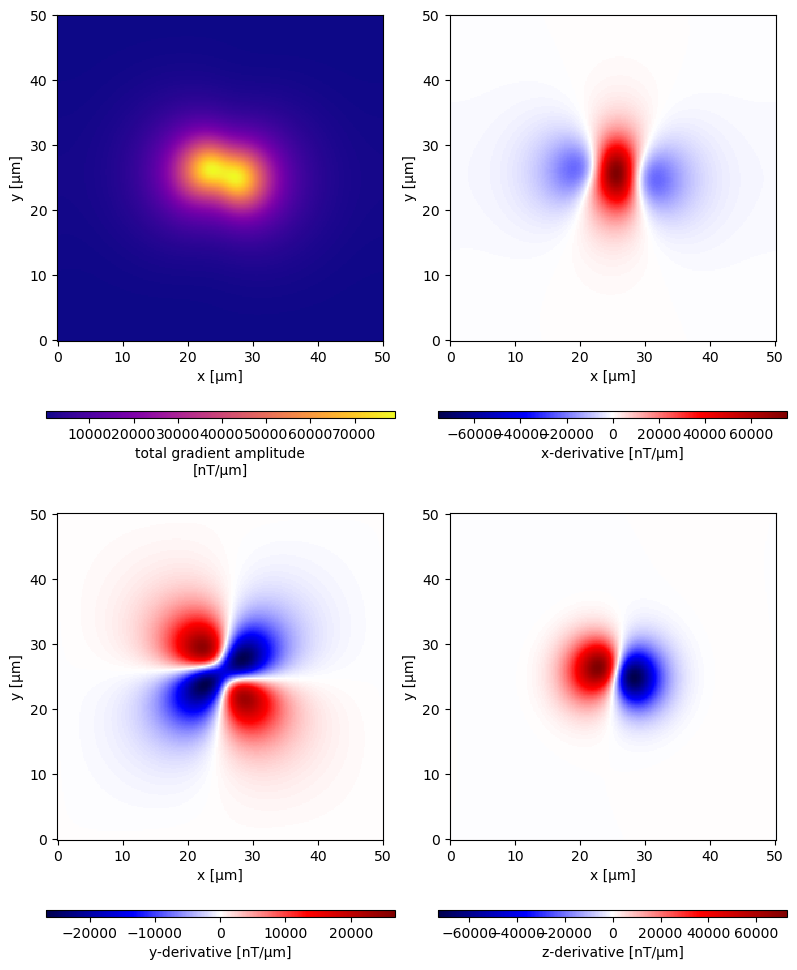

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

## Euler Deconvolution

Run the Euler Deconvolution on each window to compare the true and estimated source positions.

In [12]:
positions = []
# for window in windows:
anomaly = data_up.sel(x=slice(10,40), y=slice(10,40)) 
position, base_level = mg.euler_deconvolution(
    anomaly.bz, 
    anomaly.x_deriv, 
    anomaly.y_deriv, 
    anomaly.z_deriv,
)
print(position, base_level)
positions.append(position)
positions = np.transpose(positions)

[25.50947956 25.75868626 -1.43981073] -100.84913777717745


Find which estimated source corresponds to each actual source.

In [13]:
dipole_coord_mean = np.array(dipole_coordinates).mean(axis=1)
z_difference = positions[2] - dipole_coord_mean[2]
print(z_difference)

[-0.43018304]


Plot the locations found and the error in z.

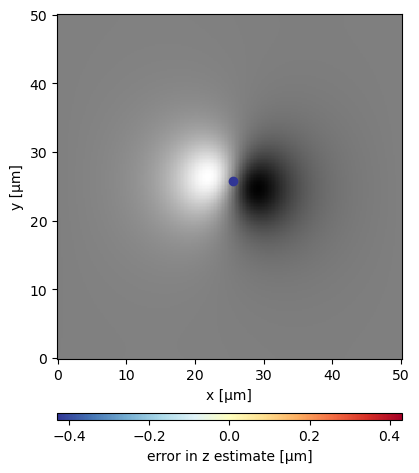

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False)

scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale)
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

## Dipole moment inversion

With the source positions found through Euler Deconvolution, we can now estimate the dipole moment through a linear inversion.

In [15]:
estimated_dipole_moments = []
estimated_stds = []

anomaly = data.sel(x=slice(10,40), y=slice(10,40)) 
moment, covariance, r2, SNR = mg.dipole_moment_inversion(
    anomaly.bz, position)
estimated_dipole_moments.append(moment)
estimated_stds = np.append(estimated_stds, mg.covariance_to_angle_std(moment, covariance))
print("R²:", r2)
print("SNR:", SNR)
print()

R²: 0.7415517975697301
SNR: 5.876288518974976



In [16]:
einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)
inc, dec, amp = mg.vector_to_angles(np.sum(dipole_moments, axis=0))
sigma_inc, sigma_dec, sigma_amp = estimated_stds
print(f"Inclination: {inc} | {float(einc)} ± {sigma_inc:.3f}")
print(f"Declination: {dec} | {float(edec)} ± {sigma_dec:.3f}")
print(f"Amplitude  : {amp} | {float(eamp)} ± {sigma_amp:.1e}")
print()

Inclination: 1.8823080082596337 | 0.4338486715209284 ± 0.159
Declination: 98.13150305925113 | 102.46478780783531 ± 0.226
Amplitude  : 7.870749028585145e-13 | 8.144669233240891e-13 ± 3.2e-15



In [17]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

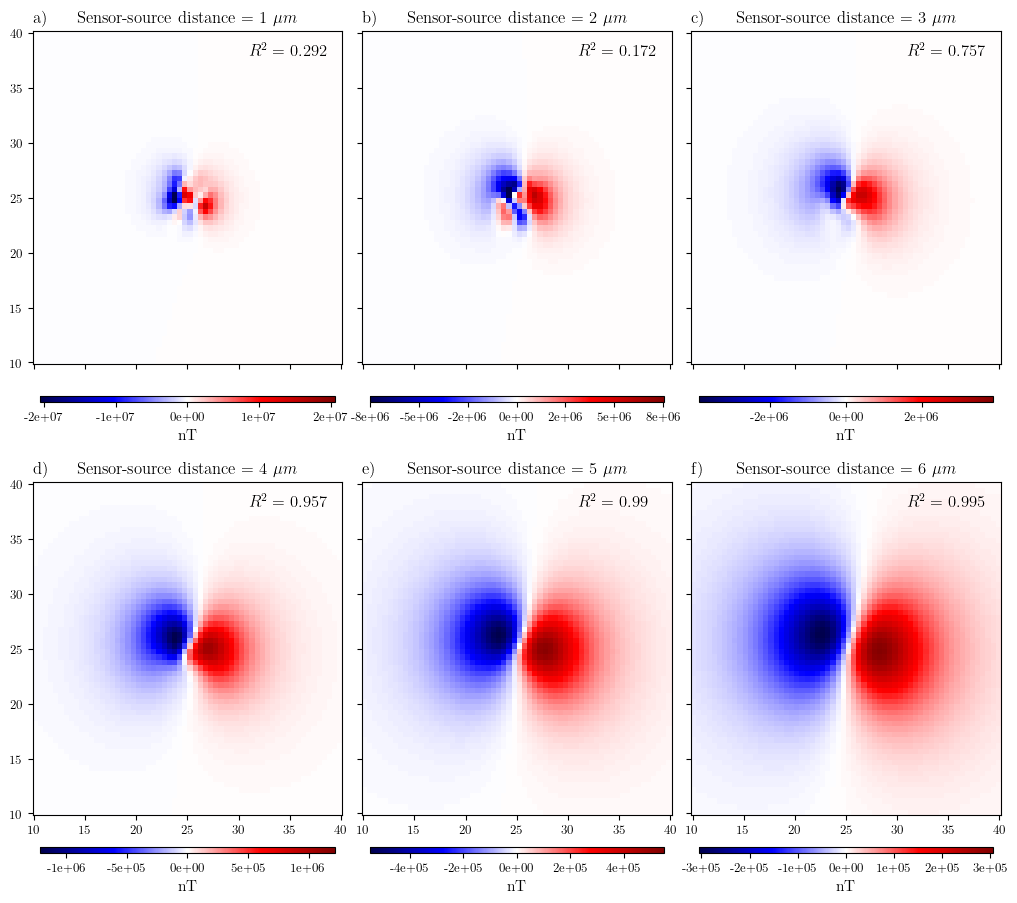

In [28]:
# Generate synthetic data
# First, we create a regular grid of observation points.

# seeds = np.arange(2, 4)
seeds = np.arange(1, 100)

distances_acum = []
r2_acum = []
snr_acum = []
delta_xc_acum = []
delta_yc_acum = []
delta_zc_acum = []
direction_misfit_acum = []
moment_misfit_acum = []

with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row", sharex="col")
    axes = axes.ravel() 

    plot = [0, 1, 2, 3, 4, 5]


    for j in (seeds[::-1]):
        plot_count = -1
        for i in (np.linspace(0, 10, 21)):
    #         print(i)

            sensor_sample_distance = 1.0  # µm
            coordinates = vd.grid_coordinates(
                region=[0, 50, 0, 50],  # µm
                shape=(100, 100),  # µm
                extra_coords=sensor_sample_distance,
            )

            # Now create the dipole model that will be used to generate the data.

            yc = 25
            xc = 25
            zc = -i
            dec = 90
            inc = 0
            amp = 1e-14

            size = 200

            np.random.seed(j)#(201) num 6 tá bom

            xc_volume = np.random.normal(xc, 0.65, size)
            yc_volume = np.random.normal(yc, 0.65, size)
            zc_volume = abs(np.random.normal(zc, 0.65, size))*(-1)
            dec_volume = np.random.normal(dec, 10, size)
            inc_volume = np.random.normal(inc, 10, size)
            amp_volume = np.random.normal(amp, 5e-14, size)

            dipole_coordinates = (
                xc_volume,  # µm
                yc_volume,  # µm
                zc_volume,  # µm
            )
            dipole_moments = mg.angles_to_vector(
                inc_volume,
                dec_volume,
                amp_volume,
            )
            # dipole_moments


            # Calculate the  𝑏𝑧 magnetic field of the dipoles and place them into an xarray.DataArray for easier handling.

            bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
            data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
            data.x.attrs = {"units": "µm"}
            data.y.attrs = {"units": "µm"}
            data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
            # data

            # Add some random noise to make it more realistic.

            noise_std_dev = 20  # nT
            data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

            # Upward continue the data to suppress the noise
            # In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

            height_difference = 0

            # Have to assign the same points as the data because the Harmonica
            # transforms give slightly different coordinates due to round-off.
            data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
            )

            data_up = data_up.assign(mg.data_gradients(data_up.bz))


            # Euler Deconvolution
            # Run the Euler Deconvolution on each window to compare the true and estimated source positions.

            positions = []
            # for window in windows:
            anomaly = data_up.sel(x=slice(10,40), y=slice(10,40)) 
            position, base_level = mg.euler_deconvolution(
                anomaly.bz, 
                anomaly.x_deriv, 
                anomaly.y_deriv, 
                anomaly.z_deriv,
            )
    #         print(position, base_level)
            positions.append(position)
            positions = np.transpose(positions)

            # Find which estimated source corresponds to each actual source.

            dipole_coord_mean = np.array(dipole_coordinates).mean(axis=1)
            z_difference = positions[2] - dipole_coord_mean[2]
            # print(z_difference)

            # Dipole moment inversion
            # With the source positions found through Euler Deconvolution, 
            # we can now estimate the dipole moment through a linear inversion.

            estimated_dipole_moments = []
            estimated_stds = []

            anomaly = data.sel(x=slice(10,40), y=slice(10,40)) 
            moment, covariance, r2, SNR = mg.dipole_moment_inversion(
                anomaly.bz, position)
            estimated_dipole_moments.append(moment)
            estimated_stds = np.append(estimated_stds, mg.covariance_to_angle_std(moment, covariance))
    #         print("R²:", r2)
    #         print("SNR:", SNR)
    #         print()


            einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)
            inc, dec, amp = mg.vector_to_angles(np.sum(dipole_moments, axis=0))
            sigma_inc, sigma_dec, sigma_amp = estimated_stds
    #         print(f"Inclination: {inc} | {float(einc)} ± {sigma_inc:.3f}")
    #         print(f"Declination: {dec} | {float(edec)} ± {sigma_dec:.3f}")
    #         print(f"Amplitude  : {amp} | {float(eamp)} ± {sigma_amp:.1e}")
    #         print()


        #     data.bz.sel(x=slice(10,40), y=slice(10,40)).plot.pcolormesh(cmap="seismic")
        #     plt.scatter(xc_volume.mean(), yc_volume.mean(), color='g', edgecolor='k', zorder=5, alpha=0.7)
        #     plt.title(r'Sensor-sample distance = %s $\mu m$'%(np.round(sensor_sample_distance-dipole_coord_mean[2],5) ))
        #     # plt.scatter(xc_volume, yc_volume, color='g', alpha=0.2)
        #     print(xc_volume.mean(), yc_volume.mean(), zc_volume.mean())
        #     print(position[0], position[1], position[2])
        #     plt.show()



            distances_acum = np.append(distances_acum, np.round(sensor_sample_distance-dipole_coord_mean[2],5))
            r2_acum = np.append(r2_acum, r2)
            snr_acum = np.append(snr_acum, SNR)
            delta_xc_acum = np.append(delta_xc_acum, positions[0] - dipole_coord_mean[0])
            delta_yc_acum = np.append(delta_yc_acum, positions[1] - dipole_coord_mean[1])
            delta_zc_acum = np.append(delta_zc_acum, positions[2] - dipole_coord_mean[2])


            dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                                    mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
            magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %

            direction_misfit_acum = np.append(direction_misfit_acum, dir_misfit)
            moment_misfit_acum = np.append(moment_misfit_acum, magm_mom_misfit)

            if j == 3:
                if i in plot:
                    plot_count += 1                
                    ax = axes[plot_count]
                    tmp = data.sel(x=slice(10,40), y=slice(10,40)).bz.plot.pcolormesh(ax=ax, cmap="seismic", 
                                                  add_colorbar=False, add_labels=False)#, vmax=1.0e7, vmin=-1.0e7)

                    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.075, shrink=0.95)#, extend='both', format='%.0e')
                    plt.colorbar(tmp, ax=ax, **cbar_kwargs, format='%.0e').set_label(label=r'nT', fontsize=11)
    #                 ax.scatter([],[], color='w', s=0.001, label=r'$R^2 = %s$'%(np.round(r2, 3)))
    #                 ax.legend()
                    ax.text(31, 38, r'$R^2 = %s$'%(np.round(r2, 3)), fontsize=12)
    #                 if ax == axes[5]:
    #                     cbar = tmp
    #                     cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.1, shrink=0.8, extend='both', format='%.0e')
    #                     plt.colorbar(cbar, ax=ax, **cbar_kwargs,
    #                            cax=fig.add_axes([0.26, -0.05, 0.5, 0.01])).set_label(label=r'nT', fontsize=12)

    for ax, letter, title in zip(axes, "a b c d e f g h i".split(), plot):
        ax.text(-0.0, 1.030, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_title(r'Sensor-source distance = %s $\mu m$'%(title+1), fontsize=12)
        ax.set_aspect("auto")

    plt.tight_layout(pad=0, h_pad=0.4, w_pad=0.4)

    fig.savefig(fig_dir / "non-dipolarity-synthetic.png", dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()

shape_acum = (len(seeds), int(len(distances_acum)/len(seeds)))
distances_acum = np.reshape(distances_acum, shape_acum)
r2_acum = np.reshape(r2_acum, shape_acum)
snr_acum = np.reshape(snr_acum, shape_acum)
delta_xc_acum = np.reshape(delta_xc_acum, shape_acum)
delta_yc_acum = np.reshape(delta_yc_acum, shape_acum)
delta_zc_acum = np.reshape(delta_zc_acum, shape_acum)
direction_misfit_acum = np.reshape(direction_misfit_acum, shape_acum)
moment_misfit_acum = np.reshape(moment_misfit_acum, shape_acum)

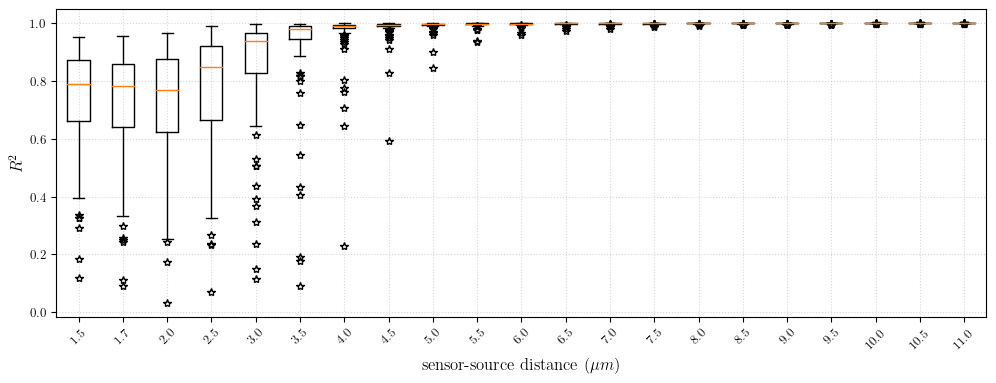

In [29]:
label=[]
for k in (distances_acum[0]):
    label.append(str(np.round(k, 1)))   

with plt.rc_context(mpl_rc):
    plt.figure(figsize=(12,4))
    plt.boxplot(r2_acum, sym='*')#flierprops={'marker': 's', 'markersize': 5, 'markerfacecolor': 'k'})
    plt.scatter([],[])    
    plt.xticks(np.arange(1,len(distances_acum[0])+1), labels=label, rotation=45)

    plt.ylabel('$R^2$', fontsize=12)
    plt.xlabel(r'sensor-source distance ($\mu m$)', fontsize=12)
    # plt.tick_params(labelright=True)
    plt.grid(alpha=0.5, linestyle=':')
    # print(label)

    plt.show()

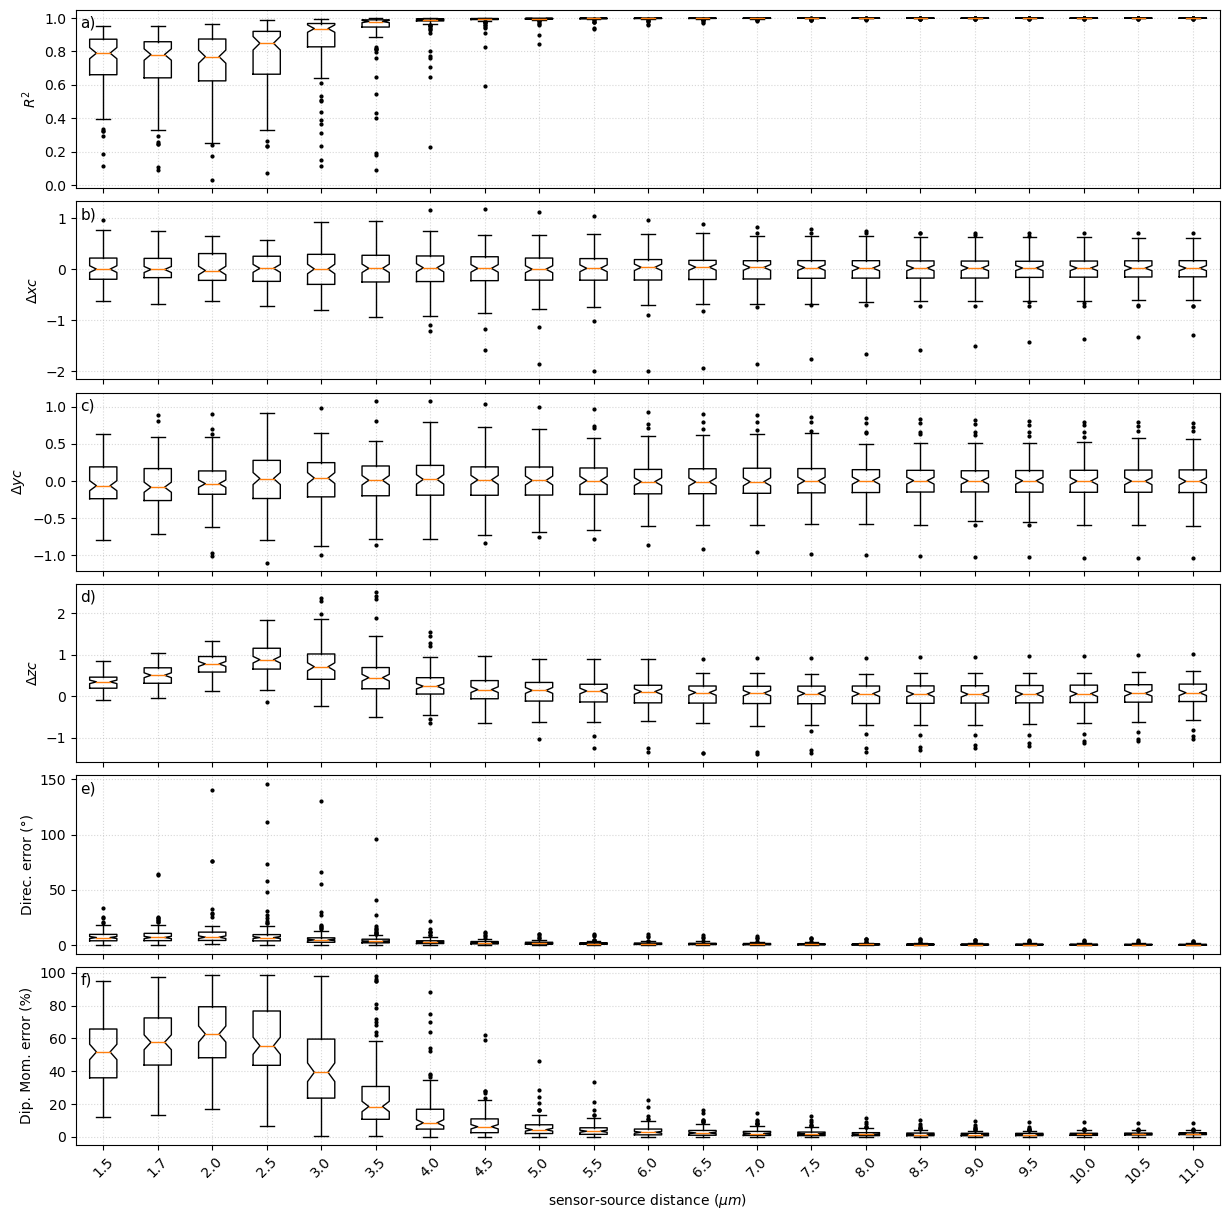

In [30]:
label=[]
for k in (distances_acum[0]):
    label.append(str(np.round(k, 1)))   


fig, axes = plt.subplots(6, 1, figsize=(12, 12), sharex=True)
parameters = [r2_acum, delta_xc_acum, delta_yc_acum, delta_zc_acum, direction_misfit_acum, moment_misfit_acum]
ylabels = [r'$R^2$', r'$\Delta xc$', r'$\Delta yc$', r'$\Delta zc$', 'Direc. error (°)', 'Dip. Mom. error (%)']
for ax, letter, parameter, ylabel in zip(axes, "a b c d e f".split(), parameters, ylabels):
    ax.boxplot(parameter,notch=True,  flierprops={'marker': '.', 'markersize': 4, 'markerfacecolor': 'k'})
    ax.set_ylabel(ylabel)
    ax.text(0.004, 0.90, f"{letter})", transform=ax.transAxes, fontsize=11)
    ax.grid(alpha=0.5, linestyle=':')
    
    
plt.xticks(np.arange(1,len(distances_acum[0])+1), labels=label, rotation=45)    
plt.xlabel(r'sensor-source distance ($\mu m$)')

plt.tight_layout(pad=0, h_pad=0.4, w_pad=0.4)
plt.show()

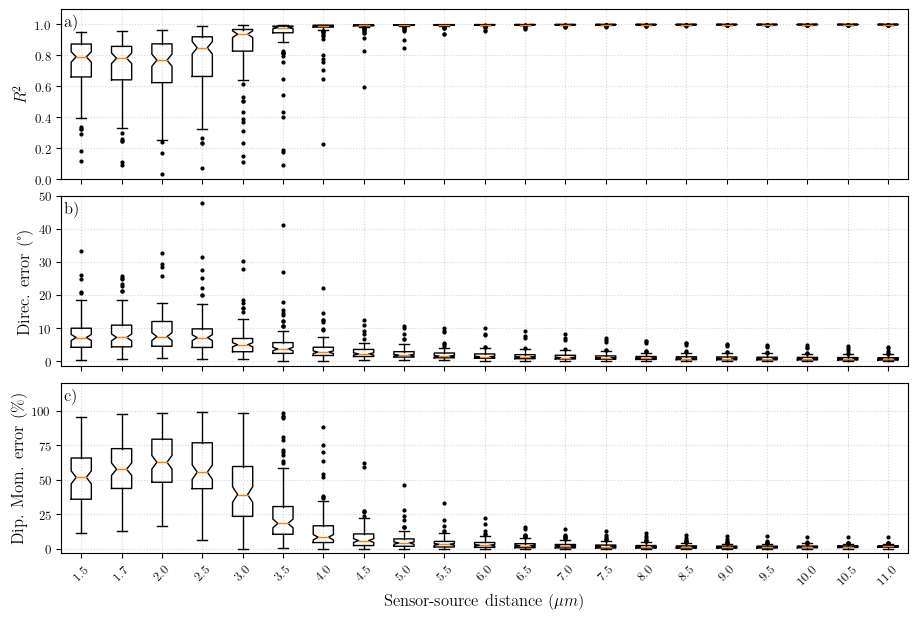

In [45]:
label=[]
for k in (distances_acum[0]):
    label.append(str(np.round(k, 1)))   

with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
    parameters = [r2_acum, direction_misfit_acum, moment_misfit_acum]
    ylabels = [r'$R^2$', 'Direc. error (°)', 'Dip. Mom. error (\%)']
    for ax, letter, parameter, ylabel in zip(axes, "a b c".split(), parameters, ylabels):
        ax.boxplot(parameter, notch=True,  flierprops={'marker': '.', 'markersize': 4, 'markerfacecolor': 'k'})
        ax.set_ylabel(ylabel, fontsize=12)
        ax.text(0.003, 0.90, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.grid(alpha=0.5, linestyle=':')


    plt.xticks(np.arange(1,len(distances_acum[0])+1), labels=label, rotation=45)    
    plt.xlabel(r'Sensor-source distance ($\mu m$)', fontsize=12)
    
    axes[0].set_ylim(0, 1.1)
    axes[1].set_ylim(-1.5, 50)
    axes[2].set_ylim(-3, 120)
    
    plt.tight_layout(pad=0, h_pad=0.8, w_pad=0.4)
    fig.savefig(fig_dir / "non-dipolarity-synthetic-inversion.png", dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()

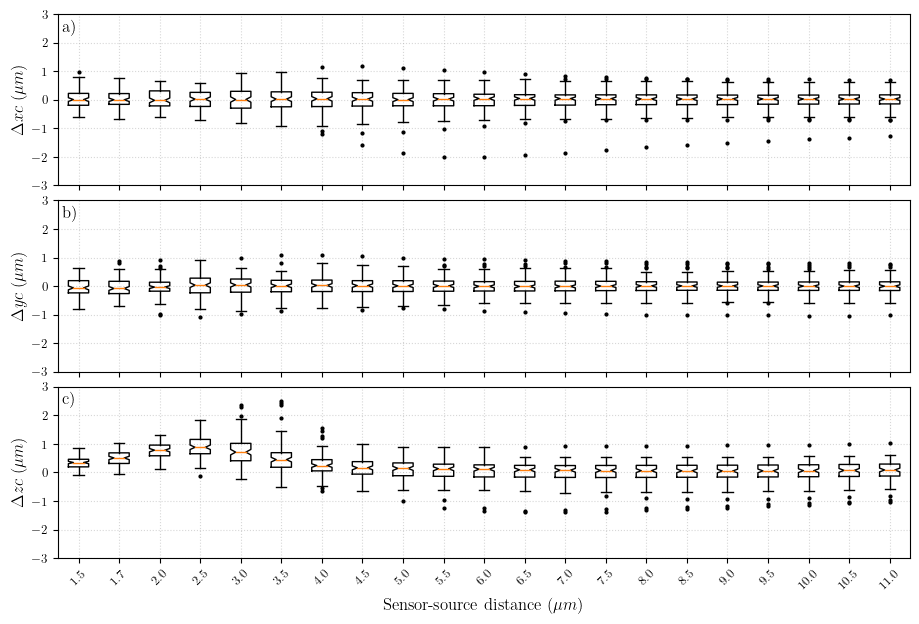

In [46]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
    parameters = [delta_xc_acum, delta_yc_acum, delta_zc_acum]
    ylabels = [r'$\Delta xc~(\mu m)$', r'$\Delta yc~(\mu m)$', r'$\Delta zc~(\mu m)$']
    for ax, letter, parameter, ylabel in zip(axes, "a b c".split(), parameters, ylabels):
        ax.boxplot(parameter,notch=True,  flierprops={'marker': '.', 'markersize': 4, 'markerfacecolor': 'k'})
        ax.set_ylabel(ylabel, fontsize=12)
        ax.text(0.004, 0.90, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.grid(alpha=0.5, linestyle=':')


    plt.xticks(np.arange(1,len(distances_acum[0])+1), labels=label, rotation=45)    
    plt.xlabel(r'Sensor-source distance ($\mu m$)', fontsize=12)
    
    axes[0].set_ylim(-3, 3)
    axes[1].set_ylim(-3, 3)
    axes[2].set_ylim(-3, 3)

    plt.tight_layout(pad=0, h_pad=0.8, w_pad=0.4)
    fig.savefig(fig_dir / "non-dipolarity-synthetic-positioning.png", dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()